In [1]:
using LinearAlgebra
using Plots


In [ ]:

# -------------------------------
# Parameters
# -------------------------------

N = 2                 # number of thin films (intermediate layers)
pol = 0               # polarization: 0 = TM, 1 = TE
lam_ini = 500.0       # initial wavelength [nm]
lam_fin = 830.0       # final wavelength [nm]
ang_ini = 0.0         # initial incidence angle [deg]
ang_fin = 80.0        # final incidence angle [deg]
nsub = 1.5            # substrate refractive index
nsup = 1.0            # superstrate refractive index
d = [50.0]            # thickness of each thin film [nm]

# -------------------------------
# Wavelength and angle grids
# -------------------------------
lam = ComplexF64.(lam_ini:1.0:lam_fin)  #λ
k0 = 2π ./ lam
ang_inc = ang_ini:0.1:ang_fin
ang = deg2rad.(ang_inc)

z0 = 0#zeros(Float64, N+1)
z=cumsum(d)
prepend!(z,z0)'
#for k in 1:N
#    z[k+1] = z[k] + d[k]
#end

# -------------------------------
# Refractive indices
# -------------------------------
nTiO2 = fill(1.9, length(lam)) ###May be differnet from constant value
n0 = fill(nsub, length(lam))
nend = fill(nsup, length(lam))

# -------------------------------
# Drude–Lorentz model for gold
# A. Vial et al.
# -------------------------------
c = 2.99792458e8                      # speed of light [m/s]
w = 2π * c ./ (lam .* 1e-9)
epsL_inf = 5.9673
wD = 2π * 2113.6e12
gD = 2π * 15.92e12
omegaL = 2π * 650.07e12
GL = 2π * 104.86e12
Deps = 1.09
#-------------------------------------
# Calculate refractive index of gold
#-------------------------------------
epsAu = ComplexF64[] #Gold ϵ
for k in eachindex(lam)
    push!(epsAu, epsL_inf - (wD^2) / (w[k] * (w[k] + 1im*gD))
          - (Deps * omegaL^2) / ((w[k]^2 - omegaL^2) + 1im*GL*w[k]))
end
nAu = sqrt.(epsAu)

# Construct refractive index matrix
nref = transpose([n0 nAu nend])  # (3 × Nλ) [n0 nAu nTiO2 nend]' ###

# -------------------------------
# Reflectance and Transmittance
# -------------------------------
Rf = zeros(length(lam), length(ang))
Tr = zeros(length(lam), length(ang))

for (ii, λ) in enumerate(lam) # For every Wvelength
    for (jj, θ) in enumerate(ang)####For every angle 
        T = Matrix{ComplexF64}(I, 2, 2)
        #rf = Matrix{ComplexF64}(I, 2, 2)
        b2 = k0[ii] * nsub * sin(θ)

        for kk in 1:length(z)
            aj = sqrt(k0[ii]^2 * nref[kk, ii]^2 - b2^2)
            aj1 = sqrt(k0[ii]^2 * nref[kk+1, ii]^2 - b2^2)

            if pol == 0
                nuj, nuj1 = nref[kk, ii]^2, nref[kk+1, ii]^2
            else
                nuj, nuj1 = 1.0, 1.0
            end

            kj = (aj * nuj1) / (aj1 * nuj)
            a11 = (1 + kj) * exp(1im * (aj - aj1) * z[kk])
            a12 = (1 - kj) * exp(-1im * (aj + aj1) * z[kk])
            a21 = (1 - kj) * exp(1im * (aj + aj1) * z[kk])
            a22 = (1 + kj) * exp(-1im * (aj - aj1) * z[kk])
            Tj = 0.5 * [a11 a12; a21 a22]
            T= Tj*T
            #println(Tj)
            #println(a11)
            #println(kk)
        end
        rf = -T[2,1] / T[2,2]
        Rf[ii, jj] = abs2(rf)
        Tr[ii, jj] = 1 - Rf[ii, jj]
        
    end
end





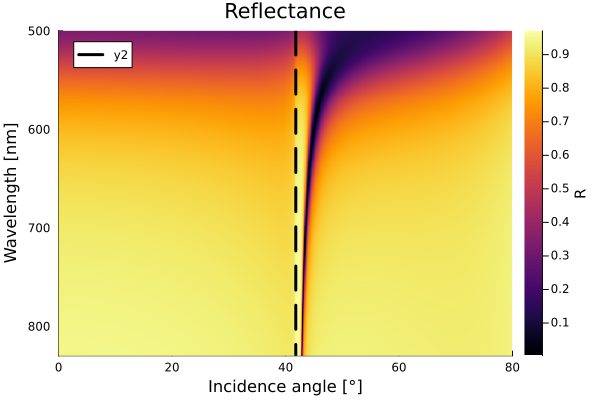

In [49]:
p1 = heatmap(ang_inc, real.(lam), Rf;
    xlabel="Incidence angle [°]",
    ylabel="Wavelength [nm]",
    title="Reflectance",
    colorbar_title="R",
    ylim=(lam_ini, lam_fin),
    xlim=(ang_ini, ang_fin),
    yflip=true)
plot!(p1, ThetaC, real.(lam), lw=3, lc=:black, ls=:dash)

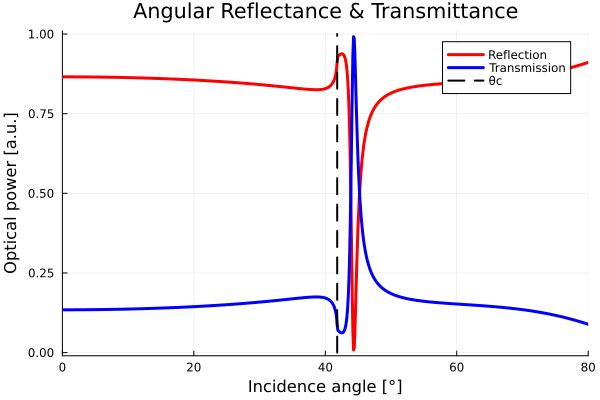

In [17]:
# Reflectance and Transmittance at specific λ
Nlam = 134
p2 = plot(ang_inc, Rf[Nlam, :], lw=3, label="Reflection", color=:red,ylims=(-0.01, 1.01),xlims=(ang_ini, ang_fin))
plot!(ang_inc, Tr[Nlam, :], lw=3, label="Transmission", color=:blue)
plot!(ThetaC, RfAux, lw=2, ls=:dash, color=:black, label="θc")
xlabel!("Incidence angle [°]")
ylabel!("Optical power [a.u.]")
#ylim!(-0.01, 1.01)
#xlim!(ang_ini, ang_fin)
plot!(legend=:topright, title="Angular Reflectance & Transmittance")

#display(p1)
#display(p2)

In [10]:
Matrix{ComplexF64}(I, 2, 2)

2×2 Matrix{ComplexF64}:
 1.0+0.0im  0.0+0.0im
 0.0+0.0im  1.0+0.0im

In [28]:
z0 = 0#zeros(Float64, N+1)
z=cumsum(d)
prepend!(z,z0)'

1×2 adjoint(::Vector{Float64}) with eltype Float64:
 0.0  50.0

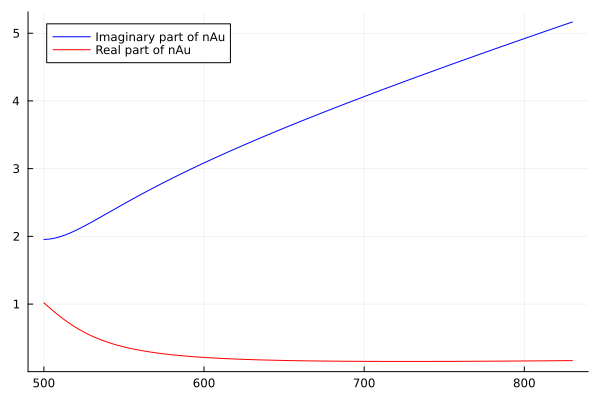

In [35]:
plot(real(lam),imag(nAu),color=:blue, label="Imaginary part of nAu")
plot!(real(lam),real(nAu),color=:red, label="Real part of nAu")

In [22]:
z

2-element Vector{Float64}:
  0.0
 50.0

In [52]:
Matrix{ComplexF64}(I, 2, 2)

2×2 Matrix{ComplexF64}:
 1.0+0.0im  0.0+0.0im
 0.0+0.0im  1.0+0.0im

In [40]:
real(sqrt.(abs.(nAu)))[end]

2.2734104857959063